In [1]:
import numpy as np, pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
train = pd.read_csv('../input/cs-training.csv', index_col=0)
test = pd.read_csv('../input/cs-test.csv', index_col=0)

In [3]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
test.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

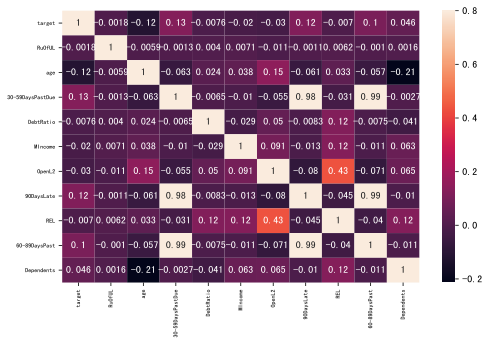

In [5]:
train_cp = train.copy()
train_cp.columns = ['target', 'RuOfUL', 'age', '30-59DaysPastDue', 'DebtRatio', 
                 'MIncome', 'OpenL2', '90DaysLate', 'REL', '60-89DaysPast','Dependents']
train.columns = ['target', 'RuOfUL', 'age', '30-59DaysPastDue', 'DebtRatio', 
                 'MIncome', 'OpenL2', '90DaysLate', 'REL', '60-89DaysPast','Dependents']
test.columns = ['target', 'RuOfUL', 'age', '30-59DaysPastDue', 'DebtRatio', 
                 'MIncome', 'OpenL2', '90DaysLate', 'REL', '60-89DaysPast','Dependents']
rel = train_cp.corr()
plt.figure(figsize=(8,5))
sns.heatmap(rel, vmax=0.8, annot=True)
plt.tick_params(axis='y', labelsize=6)
plt.tick_params(axis='x', labelsize=6)
plt.show()

In [6]:
train['DebtRatio'][train['DebtRatio']>1].count()

35137

In [7]:
train.isnull().sum()

target                  0
RuOfUL                  0
age                     0
30-59DaysPastDue        0
DebtRatio               0
MIncome             29731
OpenL2                  0
90DaysLate              0
REL                     0
60-89DaysPast           0
Dependents           3924
dtype: int64

# 大致思路
<pre>
通过观察上述汇总和原数据，大概有几个问题：

1、age=0
    训练集里有一个样本age为0,属于乱填，并且这个异常值在测试集里没有出现
    
    处理：删除该样本



2、特征冗余
    这里的老赖分3个等级，拖了30-59天、60-89天、超过90天的，这3个变量相关度很高，说明基本都是一批人
    
    处理：保留和目标特征相关度较高的一个
    
    
    
3、debtratio>1
    这个特征是指还款、赡养费、生活开销占毛月收入比例，训练集有35137个样本大于1（测试集也不少）
    对于这个我有几个猜想：
    1.确实入不敷出，可能收入差的一点钱家里一起分担掉了，那么dabtratio应该接近1的
    2.家里有矿、有人包养，月收入几乎没有但挺会花钱的
    3.debtratio可能是官方根据支出和收入计算来的，而收入有的人可能乱填成很小
    4.收入没填的，可能系统默认当作1,因为分母不能为0（在原数据里可以看到，收入缺失的debtratio都是几位数）
    5.可能这个人很多信息都是乱填的
    
    处理：
        既然有很多种情况，只好通过后面分箱，看能不能把大于1的样本分出几部分，如果不能就作为一类
        考虑到debtratio数据可能是后期算来的，如果debt统计正确的话，我们可能可以把它做成一个新变量
    

4、MonthlyIncome的缺失和异常值
    训练集有29731个缺失值（测试集也很多），也有很多很低的值，例如个位数、两位数等
    我们不能否认可能部分极低值的真实性
    缺失值太多，而该特征和其他特征相关度都极低，用机器学习补全也效果不好
    
    处理：
    1、月收入缺失的样本单独作为一类
    2、收入极低的样本通过后期分箱看能分出几组来
    
    
5、RevolvingUtilizationOfUnsecuredLines>1
    这个变量指信用额度的使用率，超过1肯定是有问题，有可能和debtratio一样，是因为额度统计错误等原因
    
    处理：后期分箱看能否划分出几个组
    
6、dependents缺失
    训练集里有3924个样本在dependents上缺失，缺失量不大，并且和age、NumberRealEstateLoansOrLines有一定相关
    
    处理：机器学习来补齐数据，这里选择randomforest
    

7、NumberOfOpenCreditLinesAndLoans和NumberRealEstateLoansOrLines
    前者指信用贷款和抵押贷款类的贷款数量，后者指抵押贷款和不动产借贷数量
    感觉前者部分包含了后者，并且所有样本在前一个特征的值都比后一个大
    
    考虑建立一个新变量
    
    
8、数据不平衡
    正负样本比例约为14:1
    
    处理：采用smote升采样至10:1，然后多次对正样本采样生成几组训练集，对学习结果求均值
</pre>

### 去掉训练集里age=0

In [49]:
train.drop(train[train['age']==0].index, inplace=True) 

### train和test都删掉两个冗余特征

In [50]:
train.drop(['60-89DaysPast', '90DaysLate'], axis=1, inplace=True)
test.drop(['60-89DaysPast', '90DaysLate'], axis=1, inplace=True)

### train和test都把income缺失值填充成-10000

In [51]:
train['MIncome'].fillna(-10000, inplace=True)
test['MIncome'].fillna(-10000, inplace=True)

### 用randomforest补上dependents的缺失值

In [77]:
train['MIncome'][train['Dependents'].isnull()]

Series([], Name: MIncome, dtype: float64)

In [55]:
# 不想用不填收入的人，因为所有没填dependents的人都没填收入，他们虽然可能是一类人，但是他们的数据可能都是乱写的
rf_train_x = train[train['MIncome']!=-10000].iloc[:, [1,2,3,4,6,7]]
rf_train_y = train[train['MIncome']!=-10000]['Dependents']

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
clf = RandomForestRegressor(random_state=0, n_estimators=500, n_jobs=-1)
clf.fit(rf_test_x, rf_test_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [61]:
# 应该能用吧，就不做严谨的评估了
clf.score(rf_test_x, rf_test_y)

0.87447288413972102

In [62]:
dep_train = np.round(clf.predict(train[train['Dependents'].isnull()].iloc[:, [1,2,3,4,6,7]]))
dep_test = np.round(clf.predict(test[test['Dependents'].isnull()].iloc[:, [1,2,3,4,6,7]]))

In [64]:
train['Dependents'][train['Dependents'].isnull()] = dep_train

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [66]:
test['Dependents'][test['Dependents'].isnull()] = dep_test

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [82]:
train.to_csv('train_pre_smote', index=False)

### smote

In [9]:
def smote(data, tag_index=None, max_amount=0, std_rate=5, kneighbor=5, kdistinctvalue=10, method='mean'):
    try:
        data = pd.DataFrame(data)
    except:
        raise ValueError
    case_state = data.iloc[:, tag_index].groupby(data.iloc[:, tag_index]).count()
    case_rate = max(case_state) / min(case_state)
    location = []
    if case_rate < 5:
        print('不需要smote过程')
        return data
    else:
        less_data = np.array(
            data[data.iloc[:, tag_index] == np.array(case_state[case_state == min(case_state)].index)[0]])
        more_data = np.array(
            data[data.iloc[:, tag_index] == np.array(case_state[case_state == max(case_state)].index)[0]])
        neighbors = NearestNeighbors(n_neighbors=kneighbor).fit(less_data)
        for i in range(len(less_data)):
            point = less_data[i, :]
            location_set = neighbors.kneighbors([less_data[i]], return_distance=False)[0]
            location.append(location_set)
        if max_amount > 0:
            amount = max_amount
        else:
            amount = int(max(case_state) / std_rate)
        times = 0
        continue_index = []
        class_index = []
        for i in range(less_data.shape[1]):
            if len(pd.DataFrame(less_data[:, i]).drop_duplicates()) > kdistinctvalue:
                continue_index.append(i)
            else:
                class_index.append(i)
        case_update = list()
        location_transform = np.array(location)
        while times < amount:
            new_case = []
            pool = np.random.permutation(len(location))[1]
            neighbor_group = location_transform[pool]
            if method == 'mean':
                new_case1 = less_data[list(neighbor_group), :][:, continue_index].mean(axis=0)
            if method == 'random':
                away_index = np.random.permutation(len(neighbor_group) - 1)[1]
                neighbor_group_removeorigin = neighbor_group[1:][away_index]
                new_case1 = less_data[pool][continue_index] + np.random.rand() * (
                    less_data[pool][continue_index] - less_data[neighbor_group_removeorigin][continue_index])
            new_case2 = np.array(pd.DataFrame(less_data[neighbor_group, :][:, class_index]).mode().iloc[0, :])
            new_case = list(new_case1) + list(new_case2)
            if times == 0:
                case_update = new_case
            else:
                case_update = np.c_[case_update, new_case]
            print('已经生成了%s条新数据，完成百分之%.2f' % (times, times * 100 / amount))
            times = times + 1
        less_origin_data = np.hstack((less_data[:, continue_index], less_data[:, class_index]))
        more_origin_data = np.hstack((more_data[:, continue_index], more_data[:, class_index]))
        data_res = np.vstack((more_origin_data, less_origin_data, np.array(case_update.T)))
        label_columns = [0] * more_origin_data.shape[0] + [1] * (
        less_origin_data.shape[0] + np.array(case_update.T).shape[0])
        data_res = pd.DataFrame(data_res)
    return data_res

In [8]:
# resample_train = smote(train, tag_index=0, std_rate=10, kdistinctvalue=8) 
#注意kdistinctvalue参数，如果一个变量unique值数量小于该值，会被认为是离散变量，会对k临近点求mode，但是
#因为默认求5个k临近点，有一定几率找到5个不同值，这时就会返回nan

In [83]:
resample_train = pd.read_csv('resample_tarin.csv')    #我是先生成好了再导入

In [93]:
resample_train[['age', '30-59DaysPastDue', 'MIncome', 'OpenL2', 'REL', 'Dependents']] = \
resample_train[['age', '30-59DaysPastDue', 'MIncome', 'OpenL2', 'REL', 'Dependents']].applymap(round)

In [105]:
resample_train['MIncome'].replace(-6000, -10000, inplace=True)  #用smote造出的收入有-10000和-6000

In [106]:
np.sort(resample_train['MIncome'].unique())

array([ -10000,       0,       1, ..., 1560100, 1794060, 3008750])

### 造变量Debt

In [115]:
pos_train_Income = resample_train['MIncome'].replace([0, -10000], 1)

In [117]:
resample_train['Debt'] = pos_train_Income * resample_train['DebtRatio']

In [120]:
resample_train['Debt'].describe()

count    163996.000000
mean       2059.699935
std        4079.164141
min           0.000000
25%         561.972206
50%        1568.494693
75%        2810.731244
max      478450.559160
Name: Debt, dtype: float64

In [121]:
pos_test_Income = test['MIncome'].replace([0, -10000], 1)

In [124]:
test['Debt'] = pos_test_Income * test['DebtRatio']

### 造linesofcredit

In [127]:
resample_train['credit'] = resample_train['OpenL2'] - resample_train['REL']
test['credit'] = test['OpenL2'] - test['REL']

In [130]:
resample_train.to_csv('train_fixed1.csv', index=False)
test.to_csv('test_fixed1.csv', index=False)